Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

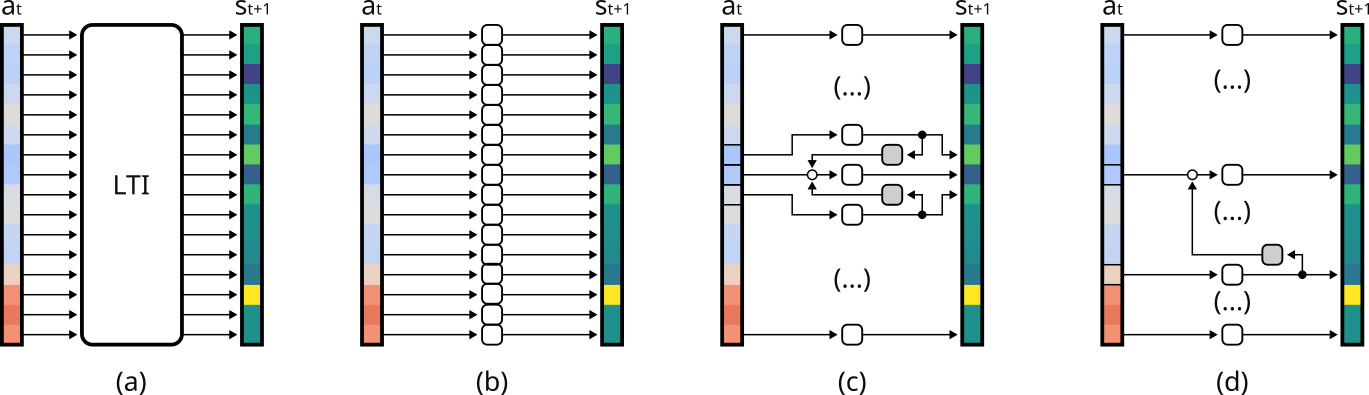

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install diffusers --quiet
#!pip install accelerate --quiet
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


In [3]:
import numpy as np, pylab as plt

from tqdm import tqdm, auto
from pathlib import Path
import os, pandas as pd

import scipy.ndimage as sm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
# setting device on GPU if available, else CPU --> for not ban
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"

### import dataset

------ Masquer cette partie

In [6]:
class CustomDataset(Dataset):
    def __init__(self, datapath, csv_file, train_file='train.zip'):
        self.metadata = pd.read_csv(datapath + csv_file)
        self.metadata["p_action"] = self.metadata["p_action"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        self.metadata["p_state"] = self.metadata["p_state"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        # # setting device on GPU if available, else CPU --> for not ban
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # import data & transform
        self.data = []
        all_data_zip = np.load(datapath + train_file) # 100 more faster !
        preprocess = transforms.Compose([transforms.Normalize([0.5], [0.5]),])
        for (i,row) in tqdm(self.metadata.iterrows(), total=self.metadata.shape[0]) :
          data = all_data_zip[row["file_name"]].astype(float)
          # scaling (channel)
          s, a = row['p_state'], row['p_action']
          data[[0,2,4]] = (data[[0,2,4]]/255)*(s[1]-s[0]) + s[0]
          data[[1,3]] = (data[[1,3]]/255)*(a[1]-a[0]) + a[0]
          # normalize (all channel)
          data = (data - data.min()) / (data.max() - data.min())
          # convert & standardize
          data = torch.tensor(data, dtype=torch.float).to(device)
          self.data += [preprocess(data)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx] # change to iterableDataset to add pandas info

In [7]:
csv_file = 'metadata.csv'
data = CustomDataset(dirpath + "datafolder_train/", csv_file)

100%|██████████| 5292/5292 [00:03<00:00, 1574.06it/s]


## Import tensorboard file (and see it)

https://www.tensorflow.org/tensorboard/dataframe_api?hl=fr

In [8]:
import tensorboard as tb
from tensorflow.python.summary.summary_iterator import summary_iterator

In [9]:
model_path = ["ddpm-spdl-32-classic/", "ddpm-spdl-32-setpoint/", "ddpm-spdl-32-setpoint-inverted/"]
experiment_id = ["events.out.tfevents.1710250977.6cfba84b2a51.952.0", "events.out.tfevents.1710253310.6cfba84b2a51.12063.0", "events.out.tfevents.1710325879.f20401a40322.2039.0"]

In [10]:
logs, loss = [], []
for m,id in zip(model_path, experiment_id):
  logs_, loss_ = [], []
  experiment = summary_iterator(dirpath + m + "logs/train_example/" + id)
  for e in experiment:
      logs_ += [e]
      for v in e.summary.value:
          if v.tag == 'loss' or v.tag == 'accuracy':
              loss_ += [v.simple_value]
  print(len(loss_))
  logs += [logs_]
  loss += [loss_]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


16550
16550
16550


In [11]:
df = pd.DataFrame(logs_)
print(df.shape)
df.head()

(49651, 1)


,0
0,"wall_time: 1710325879.5178297\nfile_version: ""..."
1,wall_time: 1710325883.1480467\nsummary {\n va...
2,wall_time: 1710325883.1481473\nsummary {\n va...
3,wall_time: 1710325883.1481912\nsummary {\n va...
4,wall_time: 1710325883.3267484\nstep: 1\nsummar...


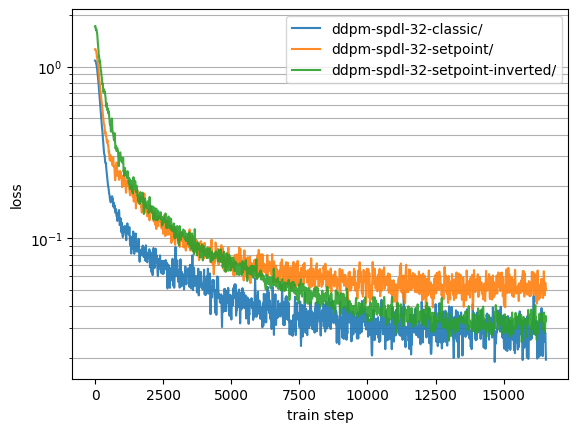

In [12]:
plt.grid(True, which='both', axis="y")
for l,m in zip(loss,model_path) :
  smooth = sm.gaussian_filter1d(l, 7)
  plt.semilogy(smooth, label=m, alpha=0.9)
  #plt.plot(np.log(smooth), label=m, alpha=0.9)
plt.ylabel("loss"); plt.xlabel("train step")
plt.legend(); plt.show()

## Test generative model (inference)

https://huggingface.co/docs/accelerate/usage_guides/checkpoint

https://huggingface.co/docs/diffusers/main/en/using-diffusers/using_safetensors

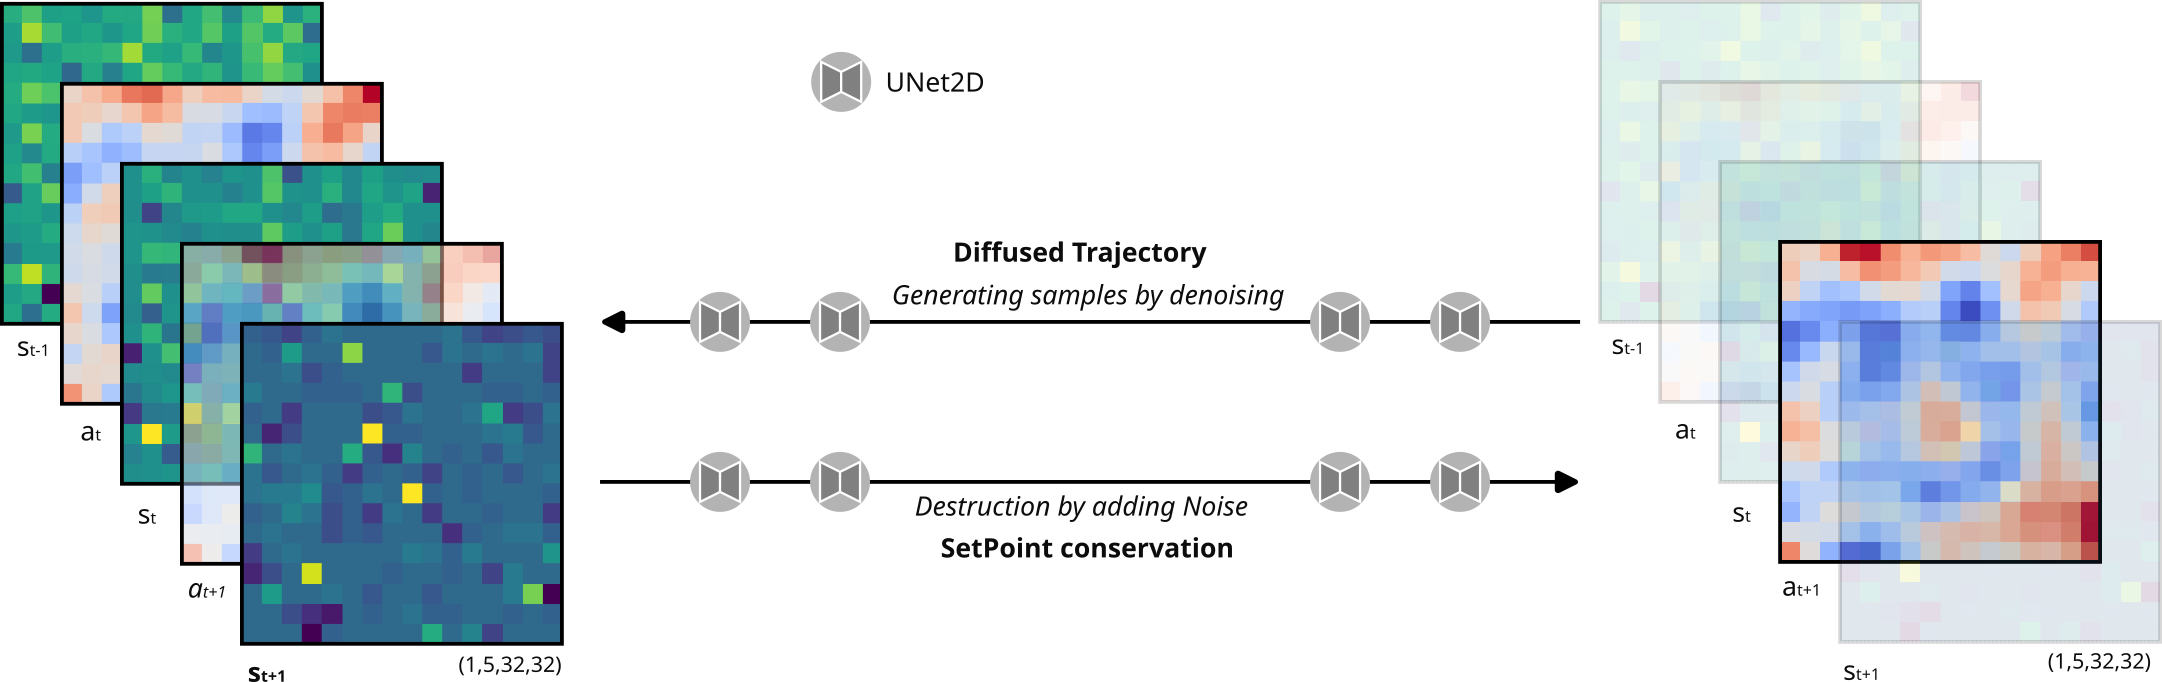

In [13]:
from diffusers import DiffusionPipeline

In [14]:
# Charger les modèles pré-entrainé
all_pipeline = []
for m in model_path :
  path = dirpath + m
  all_pipeline += [DiffusionPipeline.from_pretrained(path, use_safetensors=True)]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# choose a pipeline
pipeline = all_pipeline[-1]
pipeline

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/ddpm-spdl-32-setpoint-inverted/",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [16]:
def evaluate(pipeline, eval_batch_size, num_inference_steps):
    # Sample some images from random noise (this is the backward diffusion process).
    denoised_sample = pipeline(
        batch_size=eval_batch_size,
        num_inference_steps=num_inference_steps,
        generator=torch.manual_seed(0),
        output_type = np.array,
    ).images
    return denoised_sample

In [17]:
num_timesteps = 3

In [18]:
# create sample with a complete noise (basic inference)
denoised_sample = evaluate(pipeline, 16, num_timesteps)

  0%|          | 0/3 [00:00<?, ?it/s]

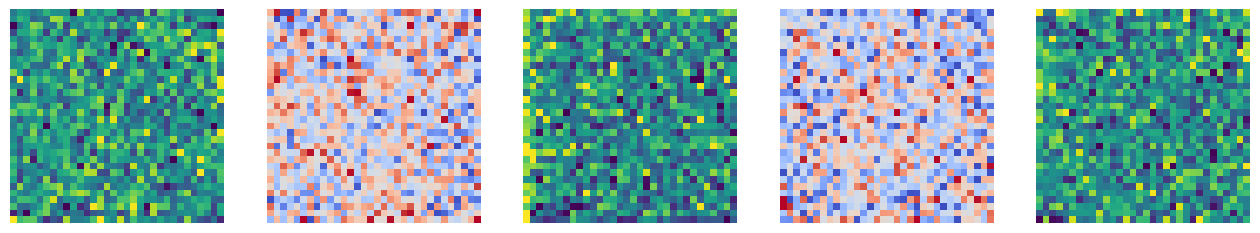

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, channel in enumerate(np.moveaxis(denoised_sample[0], -1,0)):
    if (i+1)%2 == 0 : axs[i].imshow(channel, cmap='coolwarm')
    else : axs[i].imshow(channel)
    axs[i].set_axis_off()
fig.show()

In [20]:
# manual step evaluation with custom input
@torch.no_grad() #--> to many RAM usage otherwise...
def custom_evaluate(pipeline, custom_input, num_inference_steps):
  image = custom_input.to(device)
  # set step values
  pipeline.scheduler.set_timesteps(num_inference_steps)
  for t in pipeline.progress_bar(pipeline.scheduler.timesteps):
      # 1. predict noise model_output
      model_output = pipeline.unet(image, t).sample
      # 2. compute previous image: x_t -> x_t-1
      image = pipeline.scheduler.step(model_output, t, image, generator=torch.manual_seed(0)).prev_sample
  return image

In [21]:
random_noise = torch.randn(16, 5, 32, 32)
# create sample with custom input (setpoint or not)
custom_denoised_sample = custom_evaluate(pipeline, torch.randn(16, 5, 32, 32), num_timesteps)

  0%|          | 0/3 [00:00<?, ?it/s]

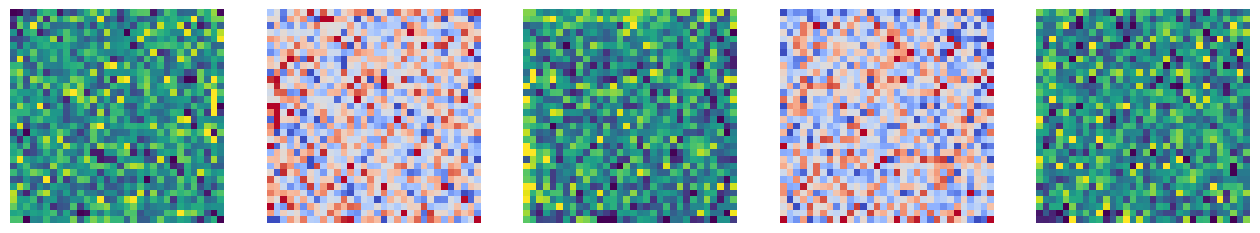

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, channel in enumerate(custom_denoised_sample[0].cpu().detach().numpy()):
    if (i+1)%2 == 0 : axs[i].imshow(channel, cmap='coolwarm')
    else : axs[i].imshow(channel)
    axs[i].set_axis_off()
fig.show()

### Test from dataset

In [23]:
train_batch_size = 16
train_dataloader = DataLoader(data, train_batch_size, shuffle=True)
sample = train_dataloader.dataset[0][None]

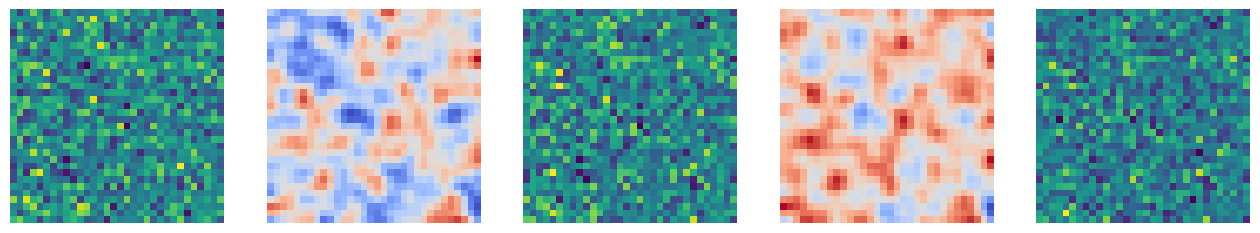

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(sample.cpu().detach().numpy()[0]):
    if (i+1)%2 == 0 : axs[i].imshow(image, cmap='coolwarm')
    else : axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [25]:
output_image_sample = custom_evaluate(pipeline, 5*sample, num_timesteps)

  0%|          | 0/3 [00:00<?, ?it/s]

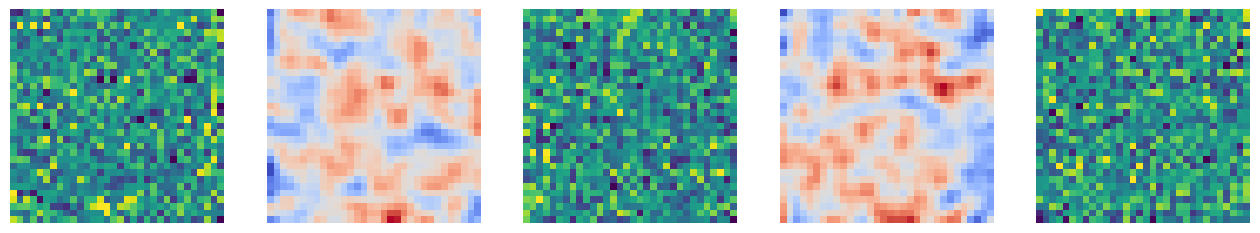

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, image in enumerate(output_image_sample[0].cpu().detach().numpy()):
    if (i+1)%2 == 0 : image = sm.gaussian_filter(image,1.); axs[i].imshow(image, cmap='coolwarm')
    else : axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Generate timeline of diffuser environnement

To do : mesurer pour chaque point des images l'ecart entre la prediction et les données d'entrée --> est-ce-que l'environnement est bien simulé ? --> faire des statistiques boxplot pour chaque modele entrainer (3 pipeline) pour sur le meme sample

Aussi, ne pas prendre en compte les bords de l'image pour la mesure statistique --> probleme frequent lorsqu'on a des CNN

mesurer l'erreur de prediction en fonction du nombre de debruitage --> 1 à 10

In [27]:
# get a timeline of experiment
sample0 = data.metadata.file_name.str.contains("sample_0_")

In [28]:
index = data.metadata.index[sample0].tolist()

In [29]:
subdata = np.concatenate([data.__getitem__(i)[None] for i in index])
subdata.shape ## don't forget to flatten for statistic

(98, 5, 32, 32)

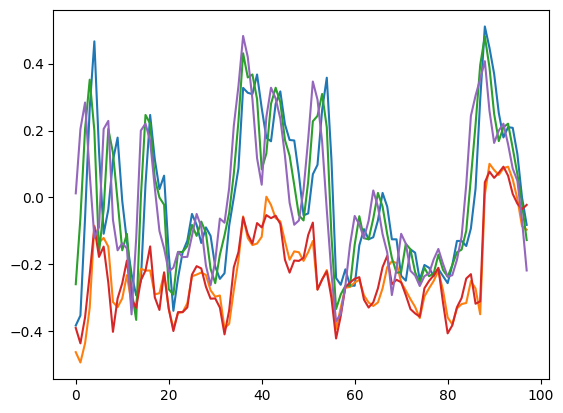

In [30]:
for i in range(5):
  plt.plot(subdata[:,i,16,16])
plt.show()

In [31]:
subdata_randn = torch.tensor(5*subdata)
subdata_generated = custom_evaluate(pipeline, subdata_randn, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

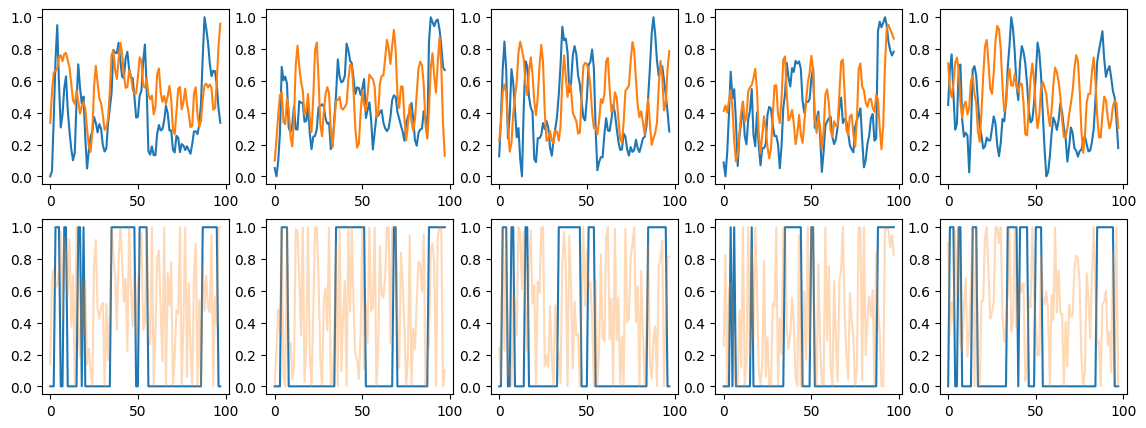

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for i in range(5):
  # TO DO : standarsize each channel --> or measurement of variation ? il y a un décalage pour le canal d'action
  d = subdata[:,i,16,16]; d = (d - d.min())/(d.max() - d.min())
  dg = subdata_generated[:,i,16,16].detach().numpy(); dg = (dg - dg.min())/(dg.max() - dg.min())
  # plot
  axs[0][i].plot(d)
  axs[0][i].plot(sm.gaussian_filter1d(dg, 1))
  axs[1][i].plot(np.where(d > 0.5, 1, 0))
  axs[1][i].plot(dg, alpha=0.3)
fig.show()

## Results - data preparation & Data Analysis

faire une normalisation par temps, pas par l'espace, puis faire un filtre gaussien, la sortie

In [65]:
def evaluate_generation(subdata, all_pipeline, scheddule=10) :
  subdata_randn = torch.tensor(5*subdata)
  sample = []
  for pipe in all_pipeline :
    subdata_generated = custom_evaluate(pipe, subdata_randn, scheddule)
    # switch axes
    q_data = subdata_randn.moveaxis(0,1)
    p_data = subdata_generated.moveaxis(0,1)
    # copy predict for time smoothing
    p_data_smooth = p_data.clone()
    q_data_smooth = q_data.clone()
    for i in range(5) :
      p, q = p_data_smooth[i], q_data_smooth[i]
      p_data_smooth[i] = torch.tensor(sm.gaussian_filter(p, (2., 2., 2.)))
      q_data_smooth[i] = torch.tensor(sm.gaussian_filter(q, (1., 1., 1.)))
    # min/max following channel and time for normalization
    q_data_norm = torch.nn.functional.normalize(q_data_smooth, dim=1)
    p_data_norm = torch.nn.functional.normalize(p_data_smooth, dim=1)
    # save
    sample += [[q_data_norm, p_data_norm]]
  return sample

In [66]:
predict = evaluate_generation(subdata, all_pipeline, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

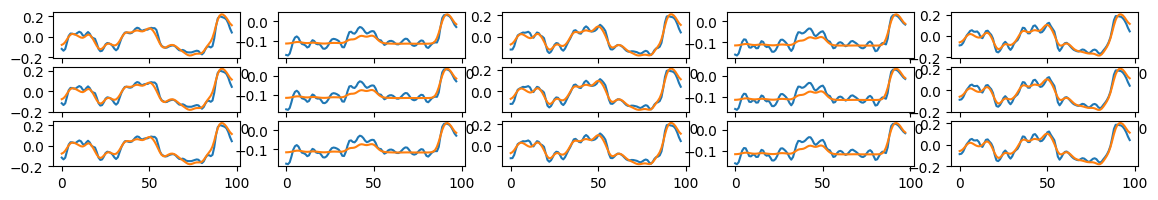

In [55]:
# verify if equivalent
fig, axs = plt.subplots(len(predict), 5, figsize=(14, 2))
for j in range(len(predict)) :
  for i in range(5):
    d = predict[j][0][i,:,16,16]
    dg = predict[j][1][i,:,16,16]
    # plot
    axs[j][i].plot(d)
    axs[j][i].plot(dg)
fig.show()

Convert to dataframe

In [61]:
def construt_dataframe(predict) :
  df_list = []
  columns_in = ["s(t-1)", "a(t)", "s(t)", "a(t+1)", "s(t+1)"]
  columns_out = ["s(t-1)g", "a(t)g", "s(t)g", "a(t+1)g", "s(t+1)g"]
  for p in predict :
    reshape_input_data = p[0].reshape(5, -1)
    reshape_output_data = p[1].reshape(5, -1)
    # in
    df_in = pd.DataFrame(reshape_input_data.T, columns=columns_in)
    # out
    df_out = pd.DataFrame(reshape_output_data.T, columns=columns_out)
    # combine
    df = pd.merge(df_in, df_out, left_index=True, right_index=True)
    df_list += [df]
  return df_list, columns_in, columns_out

In [62]:
df_list, columns_in, columns_out = construt_dataframe(predict)

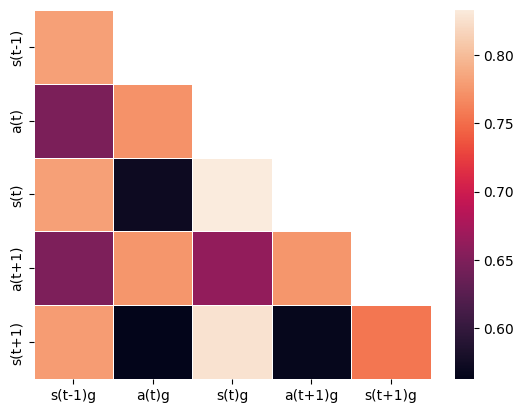

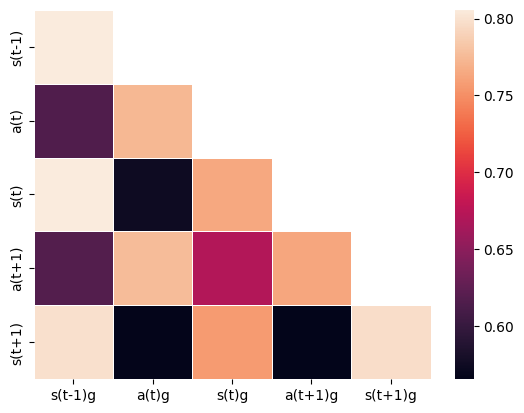

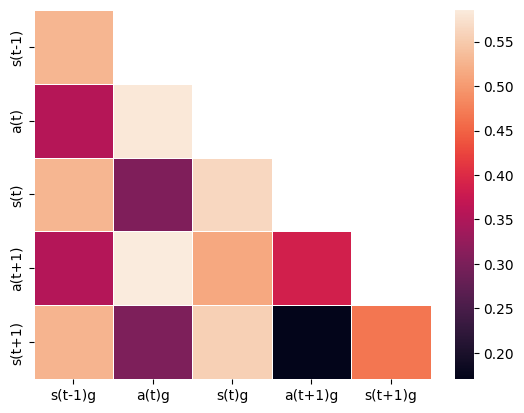

In [63]:
import seaborn as sns

for df in df_list :
  # add random comparison, and only one channel
  corr = df.corr()
  subcorr = corr[:5][columns_out]
  mask = np.triu(np.ones_like(subcorr, dtype=bool))
  mask[np.diag_indices_from(mask)] = False
  sns.heatmap(subcorr, mask=mask, linewidths=.5)
  plt.show()

## Source :


https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/?rdt=36200

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

https://diffusion-planning.github.io/

https://huggingface.co/docs/diffusers/tutorials/basic_training

Attention : Stable diffusion est different de diffusion, car espace latent : https://arxiv.org/abs/2112.10752 (impossible from scratch, uniquement pretrained https://www.databricks.com/blog/stable-diffusion-2 )

ici, juste un UNet : https://arxiv.org/abs/1505.04597

https://github.com/opendilab/awesome-diffusion-model-in-rl

ici : Unconditional diffusion